In [1]:
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin

from graph import create_graph, visualize_graph, find_clique
from signal_сlassification import generate_synthetic_data, preprocess_data, train_binary_svm

/content/graph.py:31: SyntaxWarning: invalid escape sequence '\ '
  P \ {v} := относительное соотнесение P единичного множества v.


Генерация синтетических данных

In [5]:
df, X, y, equivalence_classes = generate_synthetic_data()
X_scaled = preprocess_data(X)
df.head(2)

,X,y,num_eq_classes
0,"[13.505694250206563, 13.551626536796732, 3.682...",start,1
1,"[20.214931451628495, 8.610080747903682, 15.504...",start,1


Создаем все уникальные пары, где слова принадлежат разным классам эквивалентности

In [7]:
unique_labels = df['y'].unique()

# все уникальные пары, где слова принадлежат разным классам эквивалентности
all_pairs = list(itertools.combinations(unique_labels, 2))
filtered_pairs = []
for pair in all_pairs:
    num_class_in_pair_1 = df[df['y'] == pair[0]]['num_eq_classes'].iloc[0]
    num_class_in_pair_2 = df[df['y'] == pair[1]]['num_eq_classes'].iloc[0]
    print(num_class_in_pair_1, num_class_in_pair_2)

    if num_class_in_pair_1 == num_class_in_pair_2:
        all_pairs.remove(pair)


classification_scores = {}

1 1
1 2
1 3
1 3
1 2
1 2
1 3
1 3
2 2
2 3
2 3
2 3
3 3


Обучаем бинарный svc для каждой пары

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# считаем svc для каждого класса
for pair in all_pairs:
    class1, class2 = pair
    cls = train_binary_svm(X_train, y_train, class1, class2)

    test_mask = (y_test == class1) | (y_test == class2)
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]
    y_pred = cls.predict(X_test_filtered)

    classification_scores[pair] = accuracy_score(y_test_filtered, y_pred)

Получаем данны граф, где ребро это точность классификации соответствующей пары слов.

Точность accuracy для каждой пары
('start', 'stop'): accuracy: 1.00
('start', 'break'): accuracy: 0.83
('start', 'left_hand'): accuracy: 0.67
('start', 'left'): accuracy: 1.00
('go', 'stop'): accuracy: 1.00
('go', 'break'): accuracy: 1.00
('go', 'left_hand'): accuracy: 1.00
('go', 'left'): accuracy: 1.00
('stop', 'left_hand'): accuracy: 1.00
('stop', 'left'): accuracy: 0.33
('break', 'left_hand'): accuracy: 1.00
('break', 'left'): accuracy: 0.67


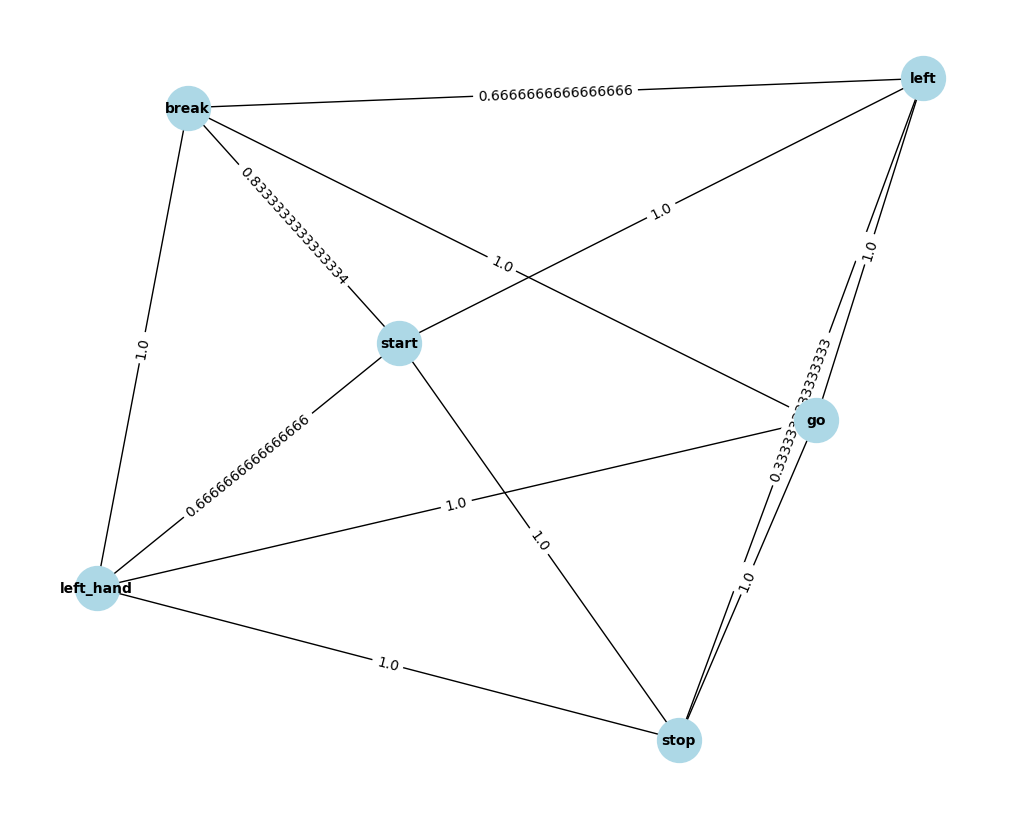

In [10]:
    print("Точность accuracy для каждой пары")
    for pair, score in classification_scores.items():
        print(f"{pair}: accuracy: {score:.2f}")

    classification_graph = create_graph(classification_scores)
    visualize_graph(classification_graph)

Выводи клику размера 3. Т.к у нас 3 класса эквивалентности. В данном примере ответом могут быть несколько клик, т.к у многих пар высокая различимость (точность классификации)

In [11]:
result = find_clique(classification_scores, 3, start_threshold=1, step=0.1)
print(result)

{'stop', 'left_hand', 'go'}


Но если бы, например, у нас был граф, как в примере ниже

In [15]:
cls_graph = {
        ('start', 'stop'): 0.7,
        ('start', 'break'): 0.8,
        ('start', 'left_hand'): 0.5,
        ('start', 'left'): 0.5,
        ('go', 'stop'): 0.5,
        ('go', 'break'): 0.55,
        ('go', 'left_hand'): 0.8,
        ('go', 'left'): 0.5,
        ('stop', 'left_hand'): 0.5,
        ('stop', 'left'): 0.6666666666666666,
        ('break', 'left_hand'): 0.8,
        ('break', 'left'): 0.6666666666666666,
    }

То мы бы остановились, когда нашли максимальную клику. Эта тройка слов

**{'break', 'left_hand', 'go'}** максимально различима относительно друг друга

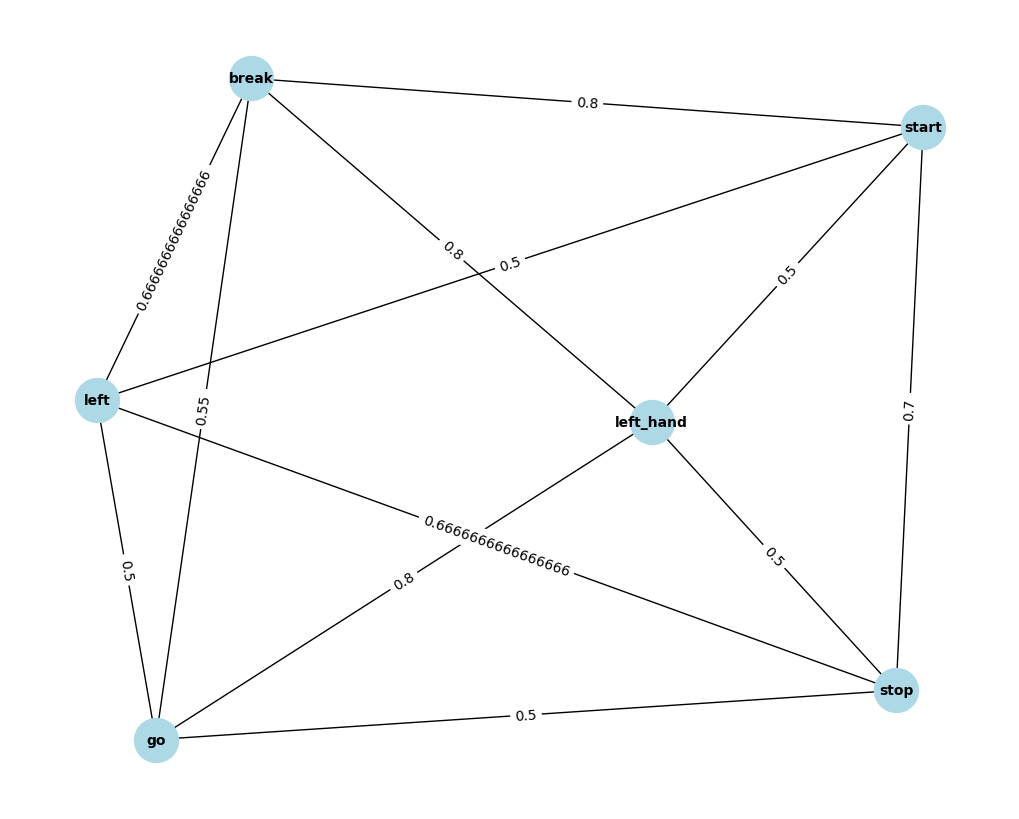

{'break', 'left_hand', 'go'}


In [16]:
visualize_graph(create_graph(cls_graph))
# поиск клики
target_k = 3
result = find_clique(cls_graph, target_k, start_threshold=0.8, step=0.1)
print(result)